## Model Machine Learning yang bisa memprediksi jenis almond dengan metode K-Nearest Neighbors

By **Quincy Team** :
Wayan Raditya Putra,
Syauqi Nabil Tasri,
Kayla Riza Putri Irjayanto.

# Proses persiapan sebelum membuat model


Membuat direktori untuk menyimpan file di google colab


In [404]:
# Import library yang diperlukan
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import accuracy_score
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import RandomizedSearchCV
from imblearn.combine import SMOTEENN
pd.set_option('display.max_columns', 3000)


In [405]:
# Proses membaca csv dan mengubahnya menjadi dataframe oleh pandas
df = pd.read_csv('Almond.csv')

In [406]:
num_duplicates = df.duplicated().sum()
print(f"Number of duplicated rows: {num_duplicates}")

df.drop(columns='Unnamed: 0', inplace = True)

Number of duplicated rows: 0


Menghandle Missing Value


In [407]:
#Dataset sebelum feature engineering
print(df)

      Length (major axis)  Width (minor axis)  Thickness (depth)     Area  \
0                     NaN          227.940628         127.759132  22619.0   
1                     NaN          234.188126         128.199509  23038.0   
2                     NaN          229.418610         125.796547  22386.5   
3                     NaN          232.763153         125.918808  22578.5   
4                     NaN          230.150742         107.253448  19068.0   
...                   ...                 ...                ...      ...   
2798                  NaN          192.709366         122.356506  18471.5   
2799                  NaN          186.254745         118.708961  17213.5   
2800                  NaN          186.196182         119.147224  17510.5   
2801                  NaN          188.660828         120.634438  17941.0   
2802           269.356903          176.023636                NaN  36683.5   

       Perimeter  Roundness  Solidity  Compactness  Aspect Ratio  \
0     6

In [408]:
# Mengecek jumlah missing value pada setiap kolom / fitur
df.isnull().sum()

Length (major axis)          857
Width (minor axis)           942
Thickness (depth)           1004
Area                           0
Perimeter                      0
Roundness                    857
Solidity                       0
Compactness                    0
Aspect Ratio                1799
Eccentricity                1799
Extent                         0
Convex hull(convex area)       0
Type                           0
dtype: int64

In [409]:
# Menampilkan datafrane beserta missing value
df[df.isna().any(axis=1)]

,Length (major axis),Width (minor axis),Thickness (depth),Area,Perimeter,Roundness,Solidity,Compactness,Aspect Ratio,Eccentricity,Extent,Convex hull(convex area),Type
0,NaN,227.940628,127.759132,22619.0,643.813269,NaN,0.973384,1.458265,NaN,NaN,0.681193,23237.5,MAMRA
1,NaN,234.188126,128.199509,23038.0,680.984841,NaN,0.957304,1.601844,NaN,NaN,0.656353,24065.5,MAMRA
2,NaN,229.418610,125.796547,22386.5,646.943212,NaN,0.967270,1.487772,NaN,NaN,0.683620,23144.0,MAMRA
3,NaN,232.763153,125.918808,22578.5,661.227483,NaN,0.965512,1.540979,NaN,NaN,0.685360,23385.0,MAMRA
4,NaN,230.150742,107.253448,19068.0,624.842706,NaN,0.951450,1.629395,NaN,NaN,0.714800,20041.0,MAMRA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2798,NaN,192.709366,122.356506,18471.5,653.345233,NaN,0.931000,1.838965,NaN,NaN,0.725739,19840.5,SANORA
2799,NaN,186.254745,118.708961,17213.5,581.688379,NaN,0.952706,1.564234,NaN,NaN,0.714016,18068.0,SANORA
2800,NaN,186.196182,119.147224,17510.5,608.315795,NaN,0.948821,1.681705,NaN,NaN,0.718999,18455.0,SANORA
2801,NaN,188.660828,120.634438,17941.0,630.759446,NaN,0.944810,1.764701,NaN,NaN,0.738191,18989.0,SANORA


Mengganti missing value dan outliers dengan median


In [410]:
# Daftar kolom yang ingin diproses
columns_to_process = ['Thickness (depth)', 'Roundness', 'Length (major axis)', 'Width (minor axis)',  'Aspect Ratio', 'Eccentricity', 'Convex hull(convex area)','Area', 'Perimeter', 'Compactness', 'Extent', 'Solidity']

# Iterasi melalui setiap kolom dalam daftar
for column in columns_to_process:
    # Menghitung Kuartil ke-25 dan Kuartil ke-75
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Menghitung batas atas dan batas bawah untuk outliers
    upper_boundary = Q3 + (IQR * 1.5)
    lower_boundary = Q1 - (IQR * 1.5)

    # Menghitung median
    median_value = df[column].median()

    # Mengganti nilai NULL (NaN) dengan median
    df[column] = df[column].fillna(median_value)

    # Mengganti outliers dengan median
    df[column] = df[column].apply(
        lambda x: median_value if (x > upper_boundary or x < lower_boundary) else x
    )

    # Menampilkan DataFrame setelah mengganti outliers dan nilai NULL di setiap kolom
    print(f"DataFrame setelah mengganti outliers dan nilai NULL di kolom '{column}' dengan median:")
    print(df[column])
    print("\n")  # Untuk memberikan jarak antara hasil tiap kolom


DataFrame setelah mengganti outliers dan nilai NULL di kolom 'Thickness (depth)' dengan median:
0       127.759132
1       128.199509
2       125.796547
3       125.918808
4       107.253448
           ...    
2798    122.356506
2799    118.708961
2800    119.147224
2801    120.634438
2802    110.280136
Name: Thickness (depth), Length: 2803, dtype: float64


DataFrame setelah mengganti outliers dan nilai NULL di kolom 'Roundness' dengan median:
0       0.472718
1       0.472718
2       0.472718
3       0.472718
4       0.472718
          ...   
2798    0.472718
2799    0.472718
2800    0.472718
2801    0.472718
2802    0.643761
Name: Roundness, Length: 2803, dtype: float64


DataFrame setelah mengganti outliers dan nilai NULL di kolom 'Length (major axis)' dengan median:
0       279.879883
1       279.879883
2       279.879883
3       279.879883
4       279.879883
           ...    
2798    279.879883
2799    279.879883
2800    279.879883
2801    279.879883
2802    269.356903
Name: Len

In [411]:
null_rows_all = df[df.isnull().any(axis=1)]
print(null_rows_all)

Empty DataFrame
Columns: [Length (major axis), Width (minor axis), Thickness (depth), Area, Perimeter, Roundness, Solidity, Compactness, Aspect Ratio, Eccentricity, Extent, Convex hull(convex area), Type]
Index: []


In [412]:
# Mengecek apakah masih ada missing value
null_counts = df.isnull().sum()

print("Jumlah nilai NULL di setiap kolom:")
print(null_counts)

Jumlah nilai NULL di setiap kolom:
Length (major axis)         0
Width (minor axis)          0
Thickness (depth)           0
Area                        0
Perimeter                   0
Roundness                   0
Solidity                    0
Compactness                 0
Aspect Ratio                0
Eccentricity                0
Extent                      0
Convex hull(convex area)    0
Type                        0
dtype: int64


In [413]:
#Menampilkan dataset setelah feature engineering

print(df)


      Length (major axis)  Width (minor axis)  Thickness (depth)     Area  \
0              279.879883          227.940628         127.759132  22619.0   
1              279.879883          234.188126         128.199509  23038.0   
2              279.879883          229.418610         125.796547  22386.5   
3              279.879883          232.763153         125.918808  22578.5   
4              279.879883          230.150742         107.253448  19068.0   
...                   ...                 ...                ...      ...   
2798           279.879883          192.709366         122.356506  18471.5   
2799           279.879883          186.254745         118.708961  17213.5   
2800           279.879883          186.196182         119.147224  17510.5   
2801           279.879883          188.660828         120.634438  17941.0   
2802           269.356903          176.023636         110.280136  36683.5   

       Perimeter  Roundness  Solidity  Compactness  Aspect Ratio  \
0     6

Uji Normalitas Dataset

In [414]:
# Coba cek nilai skew (nanti)/ uji Kolmogorov-Smirnov test atau Shapiro wilk test

# Uji Normalitas Nilai Variabel

for column in columns_to_process :
  stat, p_value = stats.shapiro(df[column])
  print(f'Statistik Shapiro-Wilk: {stat:.3f}, P-value: {p_value:.3f}')
  if p_value > 0.05:
    print(f" {column} Distribusi normal (gagal tolak H0)")
  else:
    print(f" {column} Distribusi tidak normal (tolak H0)")



Statistik Shapiro-Wilk: 0.924, P-value: 0.000
 Thickness (depth) Distribusi tidak normal (tolak H0)
Statistik Shapiro-Wilk: 0.955, P-value: 0.000
 Roundness Distribusi tidak normal (tolak H0)
Statistik Shapiro-Wilk: 0.915, P-value: 0.000
 Length (major axis) Distribusi tidak normal (tolak H0)
Statistik Shapiro-Wilk: 0.942, P-value: 0.000
 Width (minor axis) Distribusi tidak normal (tolak H0)
Statistik Shapiro-Wilk: 0.680, P-value: 0.000
 Aspect Ratio Distribusi tidak normal (tolak H0)
Statistik Shapiro-Wilk: 0.732, P-value: 0.000
 Eccentricity Distribusi tidak normal (tolak H0)
Statistik Shapiro-Wilk: 0.945, P-value: 0.000
 Convex hull(convex area) Distribusi tidak normal (tolak H0)
Statistik Shapiro-Wilk: 0.942, P-value: 0.000
 Area Distribusi tidak normal (tolak H0)
Statistik Shapiro-Wilk: 0.976, P-value: 0.000
 Perimeter Distribusi tidak normal (tolak H0)
Statistik Shapiro-Wilk: 0.877, P-value: 0.000
 Compactness Distribusi tidak normal (tolak H0)
Statistik Shapiro-Wilk: 0.970, P-va

Split Data Train dan Test


In [415]:
# Split between Features and Target
x = df.drop("Type", axis=1)
y = df['Type']

smoteenn = SMOTEENN(random_state=42)
x_new, y_new = smoteenn.fit_resample(x, y)

# Split between Train-Set and Test-Set
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, test_size=0.20, random_state=42)

print('Train Size : ', y_train.shape)
print('Test Size  : ', y_test.shape)

Train Size :  (373,)
Test Size  :  (94,)


Feature Selection Dengan ANOVA F-test atau Analysis of Variance F-test (dengan fungsi f_clasif)

In [416]:
#Hasil Feature Selection
selector = SelectKBest(score_func=f_classif, k=12)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
selected_features = x.columns[selector.get_support()]

X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features)
X_test_selected = pd.DataFrame(X_test_selected, columns=selected_features)

print("Selected features:", selected_features.tolist())

Selected features: ['Length (major axis)', 'Width (minor axis)', 'Thickness (depth)', 'Area', 'Perimeter', 'Roundness', 'Solidity', 'Compactness', 'Aspect Ratio', 'Eccentricity', 'Extent', 'Convex hull(convex area)']


In [417]:
#Feature Scaling Data dengan MinMaxScaler karena distribusi data tidak normal
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train_selected)

X_test_scaled = scaler.transform(X_test_selected)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_selected.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_selected.columns)

# Simpan scaler
pickle.dump(scaler, open('scaler.pkl', 'wb'))

# Download the .pkl file
# files.download('scaler.pkl')

In [418]:
# Feature Encoding Target

encoder = LabelEncoder()
encoder.fit(y_train)

y_train_encoded = encoder.transform(y_train)
y_test_encoded = encoder.transform(y_test)

In [419]:
# Training using KNN

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train_encoded)

KNeighborsClassifier(n_neighbors=3)

In [420]:
# Model Prediction

y_pred_train_knn = knn.predict(X_train_scaled)
y_pred_test_knn = knn.predict(X_test_scaled)

In [421]:
# Model Evaluation - Train Set & Test Set

print(classification_report(y_train_encoded, y_pred_train_knn))
print(classification_report(y_test_encoded, y_pred_test_knn))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       185
           1       0.86      0.90      0.88       102
           2       0.91      0.85      0.88        86

    accuracy                           0.92       373
   macro avg       0.91      0.90      0.90       373
weighted avg       0.92      0.92      0.92       373

              precision    recall  f1-score   support

           0       0.91      0.93      0.92        45
           1       0.74      0.67      0.70        21
           2       0.83      0.86      0.84        28

    accuracy                           0.85        94
   macro avg       0.83      0.82      0.82        94
weighted avg       0.85      0.85      0.85        94



In [422]:
print(y_train.value_counts())  # Periksa distribusi kelas

Type
MAMRA      185
REGULAR    102
SANORA      86
Name: count, dtype: int64


In [423]:
# Cek akurasi pada data training
train_accuracy = knn.score(X_train_scaled, y_train_encoded)
print(f'Akurasi pada data training: {train_accuracy:}')

# Cek akurasi pada data testing
test_accuracy = knn.score(X_test_scaled, y_test_encoded)
print(f'Akurasi pada data testing: {test_accuracy:}')

Akurasi pada data training: 0.9168900804289544
Akurasi pada data testing: 0.851063829787234


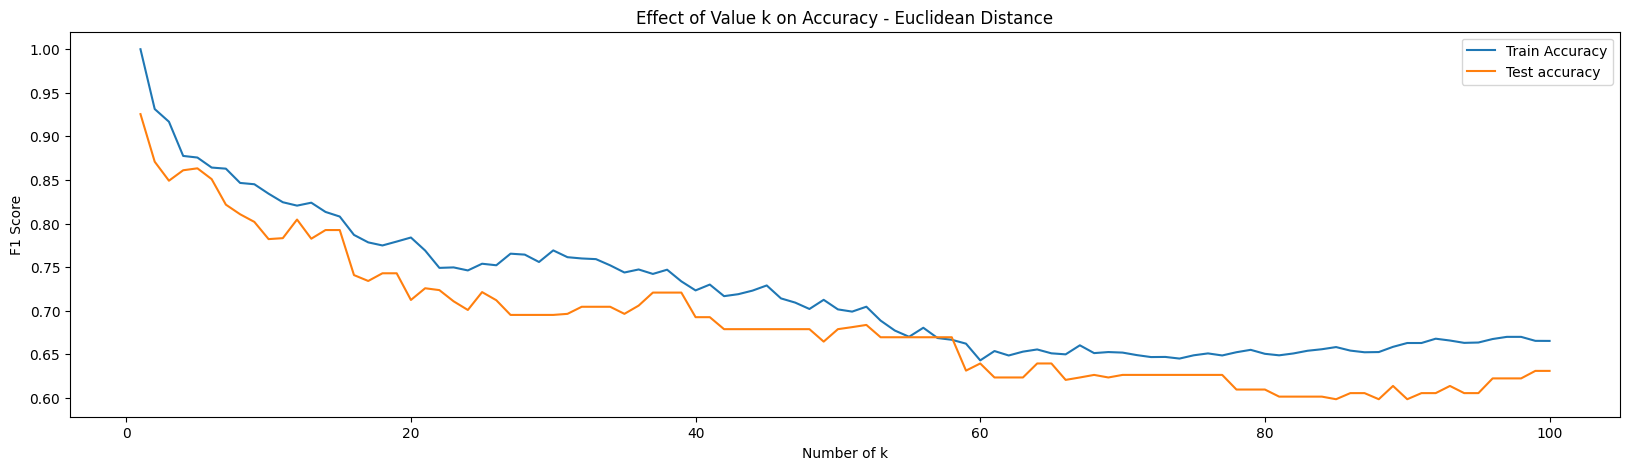

In [424]:
# Get F1 Score from k = 1 to k = 15
# %%time

max_k = 100

train_acc = []
test_acc = []

for loop in range (1, max_k+1):
  knn = KNeighborsClassifier(n_neighbors = loop)
  knn.fit(X_train_scaled, y_train_encoded)

  y_pred_train_knn = knn.predict(X_train_scaled)
  y_pred_test_knn = knn.predict(X_test_scaled)

  train_acc.append(f1_score(y_train_encoded, y_pred_train_knn, average='weighted'))
  test_acc.append(f1_score(y_test_encoded, y_pred_test_knn, average='weighted'))

# Visualization of Accuracy
plt.figure(figsize=(20,5))
plt.title('Effect of Value k on Accuracy - Euclidean Distance')
plt.plot(range(1, max_k+1), train_acc, label='Train Accuracy')
plt.plot(range(1, max_k+1), test_acc, label='Test accuracy')

plt.legend()
plt.xlabel('Number of k')
plt.ylabel('F1 Score')
plt.show()

In [425]:
# Inisialisasi model
model = KNeighborsClassifier(n_neighbors=3)

# Melatih model dengan training set
model.fit(X_train_scaled, y_train_encoded)


KNeighborsClassifier(n_neighbors=3)

In [426]:
# Prediksi hasil dari testing set
y_pred = model.predict(X_test_scaled)

# Evaluasi akurasi model
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Akurasi Sebelum Hyper Parameter Tuning: {accuracy:.3f}")

Akurasi Sebelum Hyper Parameter Tuning: 0.851


# Akurasi Model Setelah Hyper Paramater Tuning


In [427]:
# Inisialisasi model K-Nearest Neighbors
model = KNeighborsClassifier()

# Definisikan distribusi parameter untuk random search
param_dist = {
    'n_neighbors': np.arange(1, 100),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],  # 'p' is relevant only for 'minkowski'
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev'],
    'leaf_size': np.arange(10, 100),
    # Removed 'p' from metric_params
    'metric_params': [None]  # This can be kept for possible future metric parameters
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,  # Menggunakan distribusi parameter untuk random search
    n_iter=100,                      # Jumlah iterasi random search
    cv=5,                            # Cross-validation
    n_jobs=-1,                       # Menggunakan semua core yang tersedia
    random_state=42,                 # Seed untuk memastikan hasil yang reproducible
    verbose=1                        # Output lebih detail
)

# Melakukan fitting model dengan data training
random_search.fit(X_train_scaled, y_train_encoded)

# Predict using the best model found
y_pred = random_search.best_estimator_.predict(X_test_scaled)



Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [428]:
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

Best Parameters: {'weights': 'distance', 'p': 1, 'n_neighbors': np.int64(5), 'metric_params': None, 'metric': 'manhattan', 'leaf_size': np.int64(30), 'algorithm': 'brute'}
Best Score: 0.8687927927927929


In [429]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)

In [430]:
# Model Evaluation - Train Set & Test Set

print(classification_report(y_train_encoded, y_pred_train_knn))
print(classification_report(y_test_encoded, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.76      0.83       185
           1       0.49      0.94      0.65       102
           2       0.69      0.21      0.32        86

    accuracy                           0.68       373
   macro avg       0.70      0.64      0.60       373
weighted avg       0.75      0.68      0.67       373

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        45
           1       0.82      0.86      0.84        21
           2       0.86      0.86      0.86        28

    accuracy                           0.90        94
   macro avg       0.88      0.89      0.89        94
weighted avg       0.91      0.90      0.90        94



In [431]:
# Evaluasi akurasi model
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Akurasi Setelah Hyper parameter tuning: {accuracy:.3f}")

Akurasi Setelah Hyper parameter tuning: 0.904


In [432]:
# Save the model to a .pkl file
with open('model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [433]:
# from google.colab import files

# # Download the .pkl file
# files.download('model.pkl')
